# Hacks for Implementing Freedman's GBM

In this notebook, I figure out the hacks needed to implement Freedman's original GBM algorithm using sklearn DecisionTreeRegressor as the weak learner and scipy minimize as the argmin method.
Basically we just need to be able to modify the tree predictions to predict the output of line search on the global loss function, instead of just predicting the mean target value from the training data.
This page on the [decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)  in the sklearn documentation is super helpful.

## sklearn decision trees

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [45]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 50)
y = np.where(x < 5, x, 5) + rng.normal(0, 0.4, size=x.shape)
x = x.reshape(-1,1)

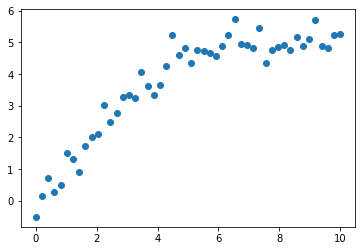

In [291]:
plt.plot(x, y, 'o')

In [46]:
reg = DecisionTreeRegressor(max_depth=2)
reg.fit(x, y)

DecisionTreeRegressor(max_depth=2)

In [47]:
# parallel arrays that give info on the nodes
pd.DataFrame({
    'children_left': reg.tree_.children_left
    , 'children_right': reg.tree_.children_right
    , 'feature': reg.tree_.feature 
    , 'threshold': reg.tree_.threshold
    , 'n_node_samples': reg.tree_.n_node_samples 
    , 'impurity': reg.tree_.impurity
})

,children_left,children_right,feature,threshold,n_node_samples,impurity
0,1,4,0,2.755102,50,2.778122
1,2,3,0,1.530612,14,1.043919
2,-1,-1,-2,-2.000000,8,0.375030
3,-1,-1,-2,-2.000000,6,0.199316
4,5,6,0,4.183673,36,0.426851
5,-1,-1,-2,-2.000000,7,0.075354
6,-1,-1,-2,-2.000000,29,0.125541


The index corresponds to the nodes in the tree.
`children_left` and `children_right` give the index of the left and right children of the given node. 
They are set to -1 on the terminal nodes.
Looks like the tree is indexed in a depth-first order.

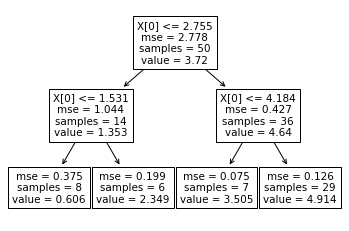

In [48]:
plot_tree(reg);

In [49]:
# find the terminal nodes that each observation lands in.
reg.apply(x)

array([2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6])

In [50]:
# find the terminal nodes that each observation lands in.
# it works on the tree_ object too
reg.tree_.apply(x.astype(np.float32))

array([2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6])

In [51]:
# terminal node id's
np.nonzero(reg.tree_.children_left == reg.tree_.children_right)[0]

array([2, 3, 5, 6])

In [52]:
# the prediction values for each node (including non terminal ones)
reg.tree_.value

array([[[3.7199241 ]],

       [[1.35310439]],

       [[0.60601261]],

       [[2.34922676]],

       [[4.64035399]],

       [[3.50513863]],

       [[4.91437149]]])

Not sure why `value` has two other dimensions.

In [70]:
# the prediction values for each node (including non terminal ones)
reg.tree_.value[:, 0, 0]

array([3.7199241 , 1.35310439, 0.60601261, 0.        , 4.64035399,
       3.50513863, 4.91437149])

In [71]:
# manually get predicted values for given feature vector observations
reg.tree_.value[:, 0, 0][reg.apply(x)]

array([0.60601261, 0.60601261, 0.60601261, 0.60601261, 0.60601261,
       0.60601261, 0.60601261, 0.60601261, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.50513863,
       3.50513863, 3.50513863, 3.50513863, 3.50513863, 3.50513863,
       3.50513863, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149])

In [72]:
# modifying one of the terminal node prediction values
reg.tree_.value[3, 0, 0] = 0.0

In [73]:
#built in predict method
reg.predict(x)

array([0.60601261, 0.60601261, 0.60601261, 0.60601261, 0.60601261,
       0.60601261, 0.60601261, 0.60601261, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.50513863,
       3.50513863, 3.50513863, 3.50513863, 3.50513863, 3.50513863,
       3.50513863, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149,
       4.91437149, 4.91437149, 4.91437149, 4.91437149, 4.91437149])

## scipy minimize

In [227]:
from scipy.optimize import minimize

In [228]:
my_fun = lambda t: (t - 4)**2 + 3
t0 = 0
res = minimize(my_fun, t0)
res.x[0]

3.999999987147814

That wasn't so bad.

## Loss Function Classes

I think we'll implement loss functions as a class that the user supplies.
The class should have two methods, `loss` and `negative_gradient`, which both take two arguments, `y` and `y_hat`.
The `loss` method should return a scalar, while the `negative_gradient` method should return an array the same size as `y` and `y_hat`.

In [230]:
class SquaredErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean((y - y_hat)**2)
    
    def negative_gradient(self, y, y_hat):
        return y - y_hat

In [280]:
# make an instance
obj = SquaredErrorLoss()

In [281]:
# loss method should return a number
obj.loss(y, y_hat)

0.8295501511145121

In [282]:
# negative_gradient method should return an array, same shape as y and y_hat
obj.negative_gradient(y, y_hat)

array([-1.11686299e+00, -4.64147769e-01,  1.14075434e-01, -3.26648669e-01,
       -1.17063299e-01,  9.00649155e-01,  7.08460552e-01,  3.01537583e-01,
        1.72142148e+00,  2.02447683e+00,  2.09022662e+00,  3.01774265e+00,
        2.48873752e+00,  2.75275547e+00, -2.21785813e-01, -1.59338006e-01,
       -2.59292946e-01,  5.62620091e-01,  1.02549945e-01, -1.83111371e-01,
        1.58358101e-01, -6.70970919e-01,  3.15798278e-01, -3.24294785e-01,
       -9.11952127e-02, -5.73258223e-01, -1.54393535e-01, -2.00280559e-01,
       -2.53188344e-01, -3.46028427e-01, -2.22892798e-02,  3.04935671e-01,
        8.11770294e-01,  1.80158884e-02, -1.24631116e-02, -9.46964002e-02,
        5.29937532e-01, -5.81464138e-01, -1.72699108e-01, -6.55416858e-02,
        2.74136707e-03, -1.58493721e-01,  2.65449303e-01, -3.18837016e-02,
        1.86115247e-01,  8.00554236e-01, -3.41700106e-02, -8.76539846e-02,
        3.06546242e-01,  3.33101084e-01])

## GBM Implementation

In [283]:
from sklearn.tree import DecisionTreeRegressor 
from scipy.optimize import minimize

class GradientBoostingMachine():
    
    def __init__(self, n_trees, learning_rate=0.1, max_depth=1):
        self.n_trees=n_trees; 
        self.learning_rate=learning_rate
        self.max_depth=max_depth;
    
    def fit(self, X, y, objective):
        self.trees = []
#         self.pseudo_residuals_list = [] 
#         self.current_predictions_list = []
        self.base_prediction = self._get_optimal_base_value(y, objective.loss)
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
#         print(current_predictions)
        for _ in range(self.n_trees):
            pseudo_residuals = objective.negative_gradient(y, current_predictions)
#             print(pseudo_residuals)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
#             print(f'Fitting tree {id(tree)}')
            tree.fit(X, pseudo_residuals)
            self._update_terminal_nodes(tree, X, y, current_predictions, objective.loss)
#             print(tree.predict(X))
#             current_predictions += self.learning_rate * tree.predict(X)
            current_predictions = current_predictions.copy() + self.learning_rate * tree.predict(X)
#             print(current_predictions)
            self.trees.append(tree)
#             self.pseudo_residuals_list.append(pseudo_residuals) 
#             self.current_predictions_list.append(current_predictions)
     
    def _get_optimal_base_value(self, y, loss):
#         print(f'optimizer has y.shape = {y.shape}')
        fun = lambda c: loss(y, c)
        c0 = y.mean()
        return minimize(fun=fun, x0=c0).x[0]
        
    def _update_terminal_nodes(self, tree, X, y, current_predictions, loss):
#         print(f'Updating tree # {id(tree)}')
        # terminal node id's
        leaf_nodes = np.nonzero(tree.tree_.children_left == tree.tree_.children_right)[0]
#         print(f'leaf nodes = {leaf_nodes}')
        # compute leaf for each sample in ``X``.
        leaf_node_for_each_sample = tree.apply(X)
        for leaf in leaf_nodes:
#             print(f'n samples in leaf {leaf} = {np.count_nonzero(leaf_node_for_each_sample == leaf)}')
            samples_in_this_leaf = np.where(leaf_node_for_each_sample == leaf)[0]
            val = self._get_optimal_leaf_value(y.take(samples_in_this_leaf, axis=0), 
                                               current_predictions.take(samples_in_this_leaf, axis=0),
                                               loss)
            tree.tree_.value[leaf, 0, 0] = val
#             print(f'value assigned = {val}')
            
    def _get_optimal_leaf_value(self, y, current_predictions, loss):
        fun = lambda c: loss(y, current_predictions + c)
        c0 = y.mean()
        return minimize(fun=fun, x0=c0).x[0]
          
    def predict(self, X):
        return (self.base_prediction + 
                self.learning_rate * np.sum([tree.predict(X) for tree in self.trees], axis=0))

### Mean Squared Error

In [285]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=1)
gbm.fit(x, y, SquaredErrorLoss())

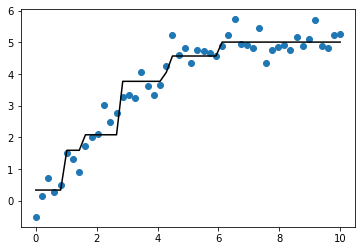

In [286]:
# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o')
plt.plot(x.ravel(), gbm.predict(x), '-k')

### Mean Absolute Error

In [287]:
class AbsoluteErrorLoss():
    
    def loss(self, y, y_hat):
        return np.mean(np.abs(y - y_hat))
    
    def negative_gradient(self, y, y_hat):
        return np.sign(y - y_hat)

In [288]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=1)
gbm.fit(x, y, AbsoluteErrorLoss())

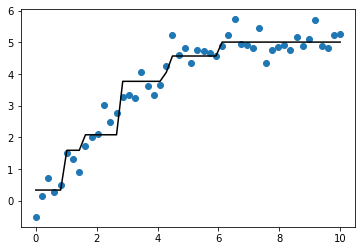

In [290]:
# fig, ax = plt.subplot()
plt.plot(x.ravel(), y, 'o')
plt.plot(x.ravel(), gbm.predict(x), '-k')

### Quantile Loss

In [309]:
rng = np.random.default_rng()
x = np.linspace(0, 10, 500)
# y = np.where(x < 5, x, 5) + rng.uniform(-2, 2, size=x.shape)
y = np.where(x < 5, x, 5) + rng.normal(0, 1, size=x.shape)
x = x.reshape(-1,1)

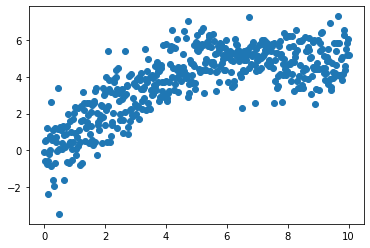

In [310]:
plt.plot(x, y, 'o')

In [311]:
class QuantileLoss():
    
    def __init__(self, alpha):
        if alpha < 0 or alpha >1:
            raise ValueError('alpha must be between 0 and 1')
        self.alpha = alpha
        
    def loss(self, y, y_hat):
        e = y - y_hat
        return np.mean(np.where(e > 0, self.alpha * e, (self.alpha - 1) * e))
    
    def negative_gradient(self, y, y_hat):
        e = y - y_hat 
        return np.where(e > 0, self.alpha, self.alpha - 1)

In [312]:
gbm = GradientBoostingMachine(n_trees=10,
                              learning_rate=1)
gbm.fit(x, y, QuantileLoss(alpha=0.9))

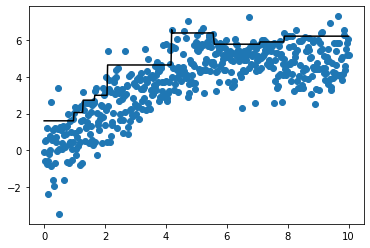

In [313]:
plt.plot(x, y, 'o')
plt.plot(x, gbm.predict(x), 'k-')